1/1 [==============================] - 1s 526ms/step


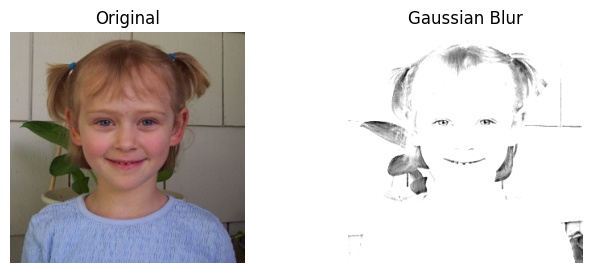

In [7]:
import os
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
pa = 10
# provide an appropriate initial value for the kernel for DepthwiseConv2D
def build_model_using_depthwiseConv2D():
    r = keras.layers.Input(shape=(None,None,1),name="Input_r")
    g = keras.layers.Input(shape=(None,None,1),name="Input_g")
    b = keras.layers.Input(shape=(None,None,1),name="Input_b")
    xr = keras.layers.DepthwiseConv2D(kernel_size = (pa,pa),depthwise_initializer= None,use_bias=False,padding='same',activation='linear',name="GaussianBlurR")(r)
    xg = keras.layers.DepthwiseConv2D(kernel_size = (pa,pa),depthwise_initializer= None,use_bias=False,padding='same',activation='linear',name="GaussianBlurG")(g)
    xb = keras.layers.DepthwiseConv2D(kernel_size = (pa,pa),depthwise_initializer= None,use_bias=False,padding='same',activation='linear',name="GaussianBlurB")(b)

    x1 = keras.layers.concatenate([xr,xg,xb], axis = -1)

    k   = keras.layers.Input(shape=(1,),name="k")
    outs = keras.layers.add([b, g, r, k * (b - xb), k * (g - xg), k * (r - xr)])
    model = keras.Model(inputs=[b, g, r, k], outputs=outs, name="Version1")
    model.trainable = False
    return model
img   = cv2.imread("/content/TestImage1.jpg")
model = build_model_using_depthwiseConv2D()

b = img[:,:,0]
g = img[:,:,1]
r = img[:,:,2]


r = r.astype(np.float32) / 255.0
g = g.astype(np.float32) / 255.0
b = b.astype(np.float32) / 255.0

r = np.expand_dims(r, axis=0)
g = np.expand_dims(g, axis=0)
b = np.expand_dims(b, axis=0)


a = model.predict([b,g,r, np.array([[0.5]])])
output = cv2.cvtColor(np.clip(a[0], 0, 1), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(img[:,:,[2,1,0]])
plt.axis(False)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(output)
plt.axis(False)
plt.title('Gaussian Blur')
plt.show()

1/1 [==============================] - 0s 334ms/step


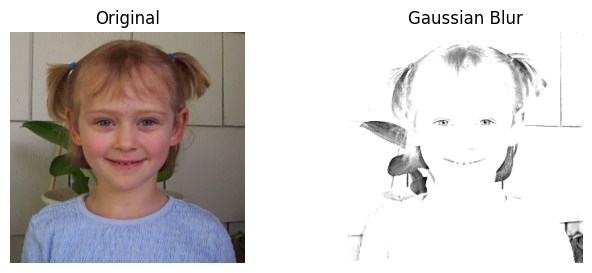

In [47]:
import os
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

pa = 10

# Set random seed for reproducibility
np.random.seed(0)

# Function to build a model using DepthwiseConv2D
def build_model_using_depthwiseConv2D():
    r = keras.layers.Input(shape=(None,None,1),name="Input_r")
    g = keras.layers.Input(shape=(None,None,1),name="Input_g")
    b = keras.layers.Input(shape=(None,None,1),name="Input_b")
    xr = keras.layers.DepthwiseConv2D(kernel_size=(pa,pa),depthwise_initializer=None,use_bias=False,padding='same',activation='linear',name="GaussianBlurR")(r)
    xg = keras.layers.DepthwiseConv2D(kernel_size=(pa,pa),depthwise_initializer=None,use_bias=False,padding='same',activation='linear',name="GaussianBlurG")(g)
    xb = keras.layers.DepthwiseConv2D(kernel_size=(pa,pa),depthwise_initializer=None,use_bias=False,padding='same',activation='linear',name="GaussianBlurB")(b)

    k = keras.layers.Input(shape=(1,),name="k")
    outs = keras.layers.add([r, g, b, k * (r - xr), k * (g - xg), k * (b - xb)])
    model = keras.Model(inputs=[r, g, b, k], outputs=outs, name="Version1")
    model.trainable = False
    return model

# Load and preprocess the image
img = cv2.imread("/content/TestImage1.jpg")
b, g, r = cv2.split(img)



r = r.astype(np.float32) / 255.0
g = g.astype(np.float32) / 255.0
b = b.astype(np.float32) / 255.0

r = np.expand_dims(r, axis=0)
g = np.expand_dims(g, axis=0)
b = np.expand_dims(b, axis=0)

# Build the model
model = build_model_using_depthwiseConv2D()

# Predict the output with a coefficient of 0.5
a = model.predict([r, g, b, np.array([[0.5]])])



a = cv2.cvtColor(a[0], cv2.COLOR_RGB2BGRA)


# Plot the original and processed images
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, [2, 1, 0]])
plt.axis(False)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(a)
plt.axis(False)
plt.title('Gaussian Blur')
plt.show()


In [10]:
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Version 1: DepthwiseConv2D for sharp/unsharp masking
def build_model_using_depthwiseConv2D():
    ins = keras.layers.Input(shape=(None,None,3), name="Input")
    k = keras.layers.Input(shape=(1,), name="k")
    x1 = keras.layers.DepthwiseConv2D((5,5), depthwise_initializer='glorot_uniform', use_bias=False, padding='same', activation='linear', name="GaussianBlur")(ins)
    outs = ins + k*(ins - x1)
    model = keras.Model(inputs=[ins, k], outputs=outs, name="Version1")
    model.trainable = False
    return model

# Version 2: Sharp/unsharp masking in YUV color space
def build_model():
    ins = keras.layers.Input(shape=(None,None,3), name="Input")
    k = keras.layers.Input(shape=(1,), name="k")
    # Convert from the RGB color space to the YUV color space
    x = keras.layers.Lambda(lambda image: keras.backend.rgb_to_yuv(image))(ins)
    y_channel = x[..., 0:1]  # Extracting Y channel
    blurred_y = keras.layers.Conv2D(1, (5, 5), kernel_initializer='glorot_uniform', use_bias=False, padding='same', name="GaussianBlur")(y_channel)
    enhanced_y = keras.layers.Add()([y_channel, k * (y_channel - blurred_y)])
    enhanced_yuv = keras.layers.Concatenate()([enhanced_y, x[..., 1:]])
    # Convert from the YUV color space to the RGB color space
    enhanced_rgb = keras.layers.Lambda(lambda image: keras.backend.yuv_to_rgb(image))(enhanced_yuv)
    model = keras.Model(inputs=[ins, k], outputs=enhanced_rgb, name="Version2")
    model.trainable = False
    return model

# Load test images
test_images = []
test_image_paths = ["TestImage1.jpg", "TestImage2.jpg", "TestImage3.jpg"]
for path in test_image_paths:
    img = cv2.imread(path)
    test_images.append(img)

# Predict with the models for each image
enhanced_images_v1 = []
enhanced_images_v2 = []
for img in test_images:
    # Predict with model v1
    enhanced_img_v1 = model_v1.predict([img[np.newaxis,:,:,[2,1,0]], np.array([[0.5]])])
    enhanced_images_v1.append(np.clip(enhanced_img_v1, 0, 255).astype(np.uint8)[0, ...])

    # Predict with model v2
    enhanced_img_v2 = model_v2.predict([img[np.newaxis,:,:,[2,1,0]], np.array([[0.5]])])
    enhanced_images_v2.append(np.clip(enhanced_img_v2, 0, 255).astype(np.uint8)[0, ...])

# Plot results for each image
for i in range(len(test_images)):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, [2, 1, 0]])
    plt.axis(False)
    plt.title('Original')

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced_images_v1[i])
    plt.axis(False)
    plt.title('Version 1: DepthwiseConv2D')

    plt.subplot(1, 3, 3)
    plt.imshow(enhanced_images_v2[i])
    plt.axis(False)
    plt.title('Version 2: YUV Color Space')

    plt.show()


NameError: name 'model_v1' is not defined

In [ ]:
def build_model():
    ins = keras.layers.Input(shape=(None,None,3),name="Input")
    k   = keras.layers.Input(shape=(1,),name="k")
    # convert from the RGB color space to the YUV color space
    x   = keras.layers.Conv2D(3,(1,1),kernel_initializer=,padding="same",use_bias=False,name="RGB2YUV")(ins)
    x1  = keras.layers.Conv2D(1,(5,5),kernel_initializer=,use_bias=False,padding='same',name="GaussianBlur")(x[...,:1])
    x   = keras.layers.Concatenate()([x[...,:1]+(x[...,:1]-x1)*k,x[...,1:]])
    # convert from the YUV color space to the RGB color space
    outs =keras.layers.Conv2D(3,(1,1),kernel_initializer=,padding="same",use_bias=False,name="YUV2RGB")(x)
    model = keras.Model(inputs=[ins,k],outputs=outs,name="Version2")
    model.trainable = False
    return model

1/1 [==============================] - 0s 74ms/step


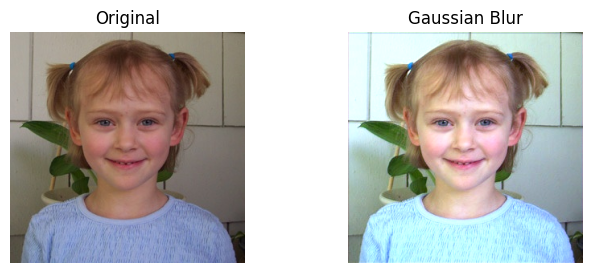

In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

# provide an appropriate initial value for the kernel for DepthwiseConv2D
def build_model_using_depthwiseConv2D():
    ins = keras.layers.Input(shape=(None,None,3),name="Input")
    k   = keras.layers.Input(shape=(1,),name="k")
    x1  = keras.layers.DepthwiseConv2D((5,5),depthwise_initializer=None ,use_bias=False,padding='same',depth_multiplier=1,activation='linear',name="GaussianBlur")(ins)
    outs = ins + k*(ins-x1)
    model = keras.Model(inputs=[ins,k],outputs=outs,name="Version1")
    model.trainable = False
    return model

model = build_model_using_depthwiseConv2D()
img   = cv2.imread("/content/TestImage1.jpg")
a     = model.predict([img[np.newaxis,:,:,[2,1,0]],np.array([[0.5]])])

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(img[:,:,[2,1,0]])
plt.axis(False)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(np.clip(a,0,255).astype(np.uint8)[0,...])
plt.axis(False)
plt.title('Gaussian Blur')
plt.show()